
# Supabase → Pandas – Datenaufbereitung

Dieses Notebook lädt Rohdaten aus der Supabase‑Datenbank, bereinigt sie
und erstellt ein `demographic`‑DataFrame mit:
* **Demografie‑Merkmalen** pro Gerät  
* **Axis of Opression** (Intersection‑Frage)  
* **Anzahl ausgefüllter Surveys** pro Gerät  

Gliederung  
0. Konfiguration & Bibliotheken  
1. Datenquellen laden  
2. Helferfunktionen  
3. Erste Survey je Gerät + Duplikate bereinigen  
4. Demografie‑Antworten extrahieren  
5. “Axis of Opression” ergänzen  
6. Label‑Mapping & optionale Ordinal‑Codes  
7. Anzahl Surveys pro Gerät  
8. Ergebnis prüfen / speichern


# 1 Import setup

In [25]:

import json, numpy as np, pandas as pd, sqlalchemy as sa

# ----------------‑ DB‑Verbindung ---------------------------------------------------
DB_URI = (
    "postgresql+psycopg2://postgres.dctqoywyodnjrpnzmdnf:"
    "w4tuxVm*pHFwZCrac9Gkob2qCNJuzuXW3aR*._fhXbhz4Fzta.9P9Y8HU37!@aws-0-eu-central-2.pooler.supabase.com:5432/postgres"
    "?sslmode=require"
)
engine = sa.create_engine(DB_URI, pool_pre_ping=True)

pd.set_option("display.max_columns", None)


In [26]:

# ---------- Surveys ---------------------------------------------------------------
surveys_df = pd.read_sql(
    '''
    SELECT id AS survey_id,
           device_id,
           completed,
           location_lat, location_lng,
           created_at
    FROM public.surveys
    ''', engine
)

# ---------- Responses -------------------------------------------------------------
responses_df = pd.read_sql(
    '''
    SELECT survey_id,
           question_id,
           response,
           created_at
    FROM public.responses
    ''', engine
)

# ---------- Questions -------------------------------------------------------------
questions_df = pd.read_sql(
    '''
    SELECT id AS question_id,
           category
    FROM public.questions
    ''', engine
)
print(len(surveys_df), "surveys,", len(responses_df), "responses")


272 surveys, 2668 responses


In [27]:

def parse_json(val):
    """String‑JSON → Python‑Objekt (oder unverändert)."""
    try:
        return json.loads(val) if isinstance(val, str) else val
    except Exception:
        return val

def first_choice(val):
    """Erstes Element aus Liste; leere {} -> None; sonst unverändert."""
    v = parse_json(val)
    if isinstance(v, list):
        return v[0] if v else None
    if isinstance(v, dict):
        return None
    return v


In [28]:

# a) nur completed
surv_done = surveys_df[surveys_df['completed']].copy()

# b) timestamp runden & duplicates killen
surv_done['ts_round'] = pd.to_datetime(surv_done['created_at']).dt.floor('S')
surv_done = surv_done.drop_duplicates(['device_id','ts_round'])

# c) erste survey_id pro device
first_surv_ids = (surv_done
                  .sort_values('created_at')
                  .drop_duplicates('device_id')['survey_id'])
print("Distinct devices:", first_surv_ids.nunique())


Distinct devices: 26


/var/folders/sf/c6nlqdjd2l3fb94dxdrh91vm0000gn/T/ipykernel_31637/3287783094.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  surv_done['ts_round'] = pd.to_datetime(surv_done['created_at']).dt.floor('S')


In [29]:

demo_qids = questions_df.query("category == 'demographic'")['question_id']

demo_raw = (responses_df
            .query("survey_id in @first_surv_ids and question_id in @demo_qids")
            .merge(surv_done[['survey_id','device_id']], on='survey_id'))

demo_norm = (demo_raw
             .assign(value=lambda d: d['response'].apply(first_choice))
             .sort_values(['device_id','question_id','created_at'])
             .drop_duplicates(['device_id','question_id']))

demo_wide = (demo_norm
             .pivot(index='device_id', columns='question_id', values='value')
             .replace({None: np.nan, 'None': np.nan}))
demo_wide.head()


/var/folders/sf/c6nlqdjd2l3fb94dxdrh91vm0000gn/T/ipykernel_31637/1033437217.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({None: np.nan, 'None': np.nan}))


question_id,age_group,different_country_than_born_in,disabilities,education,employment_status,gender,household_members,household_members_financing,info_questions_about_you,monthly_household_income,sex,sexual_orientation
device_id,,,,,,,,,,,,
1IIJ-CDFW-46VP,age_group_2635,different_country_than_born_in_no,disabilities_no,education_university_degree,employment_status_employed,gender_male,household_members_3,household_members_financing_2,NaN,monthly_household_income_more_than_chf_10000,sex_female,sexual_orientation_straight
1SMH-8HOX-E1HX,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_5,household_members_financing_2,NaN,monthly_household_income_more_than_chf_10000,sex_female,sexual_orientation_straight
20LN-4X5H-UXWX,age_group_5665,NaN,disabilities_no,education_maturafmshms_or_equivalent,employment_status_employed,gender_trans_man,household_members_6,household_members_financing_6,NaN,monthly_household_income_chf_60007500,sex_female,sexual_orientation_asexual
4RKD-HU7N-HXI2,NaN,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_3,household_members_financing_3,NaN,monthly_household_income_chf_30004500,sex_female,sexual_orientation_straight
678K-202G-SYCD,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_1_living_alone,household_members_financing_2,NaN,monthly_household_income_less_than_chf_1500,sex_female,sexual_orientation_straight


In [30]:

AXIS_QID = 'axis_of_opression'

axis_raw = (responses_df
            .query('question_id == @AXIS_QID and survey_id in @first_surv_ids')
            .merge(surv_done[['survey_id','device_id']], on='survey_id')
            .drop_duplicates('device_id'))

axis_raw['axis_codes'] = axis_raw['response'].apply(
    lambda x: ';'.join(parse_json(x)) if isinstance(parse_json(x), list) else None
)

axis_wide = axis_raw.set_index('device_id')[['axis_codes']]

demo_all = demo_wide.join(axis_wide, how='left')
demo_all.head()


,age_group,different_country_than_born_in,disabilities,education,employment_status,gender,household_members,household_members_financing,info_questions_about_you,monthly_household_income,sex,sexual_orientation,axis_codes
device_id,,,,,,,,,,,,,
1IIJ-CDFW-46VP,age_group_2635,different_country_than_born_in_no,disabilities_no,education_university_degree,employment_status_employed,gender_male,household_members_3,household_members_financing_2,NaN,monthly_household_income_more_than_chf_10000,sex_female,sexual_orientation_straight,axis_of_opression_no
1SMH-8HOX-E1HX,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_5,household_members_financing_2,NaN,monthly_household_income_more_than_chf_10000,sex_female,sexual_orientation_straight,axis_of_opression_yes_because_of_my_social_or_...
20LN-4X5H-UXWX,age_group_5665,NaN,disabilities_no,education_maturafmshms_or_equivalent,employment_status_employed,gender_trans_man,household_members_6,household_members_financing_6,NaN,monthly_household_income_chf_60007500,sex_female,sexual_orientation_asexual,axis_of_opression_yes_because_of_my_clothing_o...
4RKD-HU7N-HXI2,NaN,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_3,household_members_financing_3,NaN,monthly_household_income_chf_30004500,sex_female,sexual_orientation_straight,axis_of_opression_no
678K-202G-SYCD,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_1_living_alone,household_members_financing_2,NaN,monthly_household_income_less_than_chf_1500,sex_female,sexual_orientation_straight,None


In [31]:

AGE_GROUP = {
    "age_group_1625": "16–25",
    # ...
}
DECODER = {'age_group': AGE_GROUP}
for col, mapping in DECODER.items():
    if col in demo_all.columns:
        demo_all[f"{col}_lbl"] = demo_all[col].map(mapping)


In [32]:

survey_counts = (surv_done
                 .groupby('device_id')['survey_id']
                 .nunique()
                 .rename('n_surveys'))
demo_all['n_surveys'] = survey_counts
demo_all['n_surveys'] = demo_all['n_surveys'].fillna(0).astype(int)
demo_all[['n_surveys']].describe()


,n_surveys
count,26.000000
mean,4.115385
std,2.916531
min,1.000000
25%,2.000000
50%,3.000000
75%,6.000000
max,12.000000


In [33]:

print("Final shape:", demo_all.shape)
demo_all.head()
# Optional:
# demo_all.to_csv('demographic_clean.csv', index=True)


Final shape: (26, 15)


,age_group,different_country_than_born_in,disabilities,education,employment_status,gender,household_members,household_members_financing,info_questions_about_you,monthly_household_income,sex,sexual_orientation,axis_codes,age_group_lbl,n_surveys
device_id,,,,,,,,,,,,,,,
1IIJ-CDFW-46VP,age_group_2635,different_country_than_born_in_no,disabilities_no,education_university_degree,employment_status_employed,gender_male,household_members_3,household_members_financing_2,NaN,monthly_household_income_more_than_chf_10000,sex_female,sexual_orientation_straight,axis_of_opression_no,NaN,4
1SMH-8HOX-E1HX,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_5,household_members_financing_2,NaN,monthly_household_income_more_than_chf_10000,sex_female,sexual_orientation_straight,axis_of_opression_yes_because_of_my_social_or_...,16–25,3
20LN-4X5H-UXWX,age_group_5665,NaN,disabilities_no,education_maturafmshms_or_equivalent,employment_status_employed,gender_trans_man,household_members_6,household_members_financing_6,NaN,monthly_household_income_chf_60007500,sex_female,sexual_orientation_asexual,axis_of_opression_yes_because_of_my_clothing_o...,NaN,1
4RKD-HU7N-HXI2,NaN,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_3,household_members_financing_3,NaN,monthly_household_income_chf_30004500,sex_female,sexual_orientation_straight,axis_of_opression_no,NaN,1
678K-202G-SYCD,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_1_living_alone,household_members_financing_2,NaN,monthly_household_income_less_than_chf_1500,sex_female,sexual_orientation_straight,None,16–25,4


In [34]:
# ------------ Nachschlage-Dictionaries ------------------------------------
AGE_GROUP = {
    "age_group_under_16": "< 16",
    "age_group_1625":     "16 – 25",
    "age_group_2635":     "26 – 35",
    "age_group_3645":     "36 – 45",
    "age_group_4655":     "46 – 55",
    "age_group_5665":     "56 – 65",
    "age_group_6675":     "66 – 75",
    "age_group_75":       "75 +",
}

SEX = {
    "sex_male":   "male",
    "sex_female": "female",
    "sex_inter":  "inter*/diverse",
}

GENDER = {
    "gender_female":                     "woman",
    "gender_male":                       "man",
    "gender_nonbinary_genderqueer":      "non-binary / gender-queer",
    "gender_trans_woman":                "trans woman",
    "gender_trans_man":                  "trans man",
    "gender_agender":                    "agender",
    "gender_inter":                      "inter* / diverse",
    "gender_other":                      "other",
}

SEXUAL_ORIENTATION = {
    "sexual_orientation_straight":    "straight / hetero",
    "sexual_orientation_homosexual":  "gay / lesbian",
    "sexuql_orientation_bisexual":    "bisexual",        # Tippfehler im Code behalten!
    "sexual_orientation_pansexual":   "pansexual",
    "sexual_orientation_asexual":     "asexual",
    "sexual_orientation_queer":       "queer",
    "sexual_orientation_other":       "other",
}

EDUCATION = {
    "education_none":                                         "no formal education",
    "education_secondary_school":                             "secondary school",
    "education_vocational_training_or_apprenticeship":        "vocational training / apprenticeship",
    "education_maturafmshms_or_equivalent":                   "Matura / equivalent",
    "education_university_of_applied_sciences_fhhf":          "university of applied sciences",
    "education_university_degree":                            "university degree",
}

HOUSEHOLD_MEMBERS = {
    "household_members_1_living_alone":   "1 (living alone)",
    "household_members_2":                "2",
    "household_members_3":                "3",
    "household_members_4":                "4",
    "household_members_5":                "5",
    "household_members_6":                "6",
    "household_members_7":                "7",
    "household_members_8":                "8",
    "household_members_9":                "9",
    "household_members_10_or_more":       "10+",
}

HOUSEHOLD_FINANCING = {
    "household_members_financing_1_person_myself_only": "1 earner (myself)",
    "household_members_financing_2":                    "2 earners",
    "household_members_financing_3":                    "3 earners",
    "household_members_financing_4":                    "4 earners",
    "household_members_financing_5":                    "5 earners",
    "household_members_financing_6":                    "6 earners",
    "household_members_financing_7":                    "7 earners",
    "household_members_financing_8":                    "8 earners",
    "household_members_financing_9":                    "9 earners",
    "household_members_financing_10_or_more":           "10+ earners",
}

HOUSEHOLD_INCOME = {
    "monthly_household_income_less_than_chf_1500":      "< CHF 1 500",
    "monthly_household_income_chf_15003000":            "CHF 1 500 – 3 000",
    "monthly_household_income_chf_30004500":            "CHF 3 000 – 4 500",
    "monthly_household_income_chf_45006000":            "CHF 4 500 – 6 000",
    "monthly_household_income_chf_60007500":            "CHF 6 000 – 7 500",
    "monthly_household_income_chf_750010000":           "CHF 7 500 – 10 000",
    "monthly_household_income_more_than_chf_10000":     "> CHF 10 000",
    "monthly_household_income_unknown":                 "unknown / prefer not to say",
}

EMPLOYMENT_STATUS = {
    "employment_status_pupil__student":  "student / pupil",
    "employment_status_employed":        "employed",
    "employment_status_selfemployed":    "self-employed",
    "employment_status_retired":         "retired",
    "employment_status_unemployed":      "unemployed",
}

AXIS_MAP = {
    "axis_of_opression_yes_because_of_my_gender":                     "gender",
    "axis_of_opression_yes_because_of_my_age":                        "age",
    "axis_of_opression_yes_because_of_my_background":                 "background",
    "axis_of_opression_yes_because_of_my_skin_colour_or_appearance":  "skin / appearance",
    "axis_of_opression_yes_because_of_my_language_or_accent":         "language / accent",
    "axis_of_opression_yes_because_of_my_social_or_financial_situation": "social / financial",
    "axis_of_opression_yes_because_of_my_clothing_or_style":          "clothing / style",
    "axis_of_opression_yes_because_of_my_sexual_orientation":         "sexual orientation",
    "axis_of_opression_yes_because_of_my_health_condition_or_a_disability": "health / disability",
    "axis_of_opression_yes_for_another_reason":                       "other reason",
    "axis_of_opression_no":                                           "no",
}

YES_NO = {       # für mehrere Spalten wiederverwendbar
    "disabilities_yes": "yes",
    "disabilities_no":  "no",
    "different_country_than_born_in_yes": "yes",
    "different_country_than_born_in_no":  "no",
}


In [35]:
DECODER = {
    "age_group":                      AGE_GROUP,
    "sex":                            SEX,
    "gender":                         GENDER,
    "sexual_orientation":             SEXUAL_ORIENTATION,
    "education":                      EDUCATION,
    "household_members":              HOUSEHOLD_MEMBERS,
    "household_members_financing":    HOUSEHOLD_FINANCING,
    "monthly_household_income":       HOUSEHOLD_INCOME,
    "employment_status":              EMPLOYMENT_STATUS,   # bleibt Mehrfach-String
    "disabilities":                   YES_NO,
    "axis_codes":                     AXIS_MAP,
    "different_country_than_born_in": YES_NO,
}

def decode_value(val: str | float, mapping: dict[str, str]):
    """Wandelt Codes in Labels; unterstützt Mehrfachantworten mit ';'."""
    if pd.isna(val):
        return np.nan
    parts = str(val).split(";")
    labels = [mapping.get(p, p) for p in parts]
    return ";".join(labels)

for col, mapping in DECODER.items():
    if col in demo_all.columns:
        lbl_col = f"{col}_lbl"
        if lbl_col not in demo_all.columns:             # schon vorhanden? → überspringen
            demo_all[lbl_col] = demo_all[col].apply(lambda v: decode_value(v, mapping))


# Raw-Codes löschen, wenn du sie nicht mehr brauchst
demo_all.drop(columns=list(DECODER.keys()), inplace=True)

# Optional: Spalten neu sortieren
demo_all = demo_all.sort_index(axis=1)


demo_all

,age_group_lbl,axis_codes_lbl,different_country_than_born_in_lbl,disabilities_lbl,education_lbl,employment_status_lbl,gender_lbl,household_members_financing_lbl,household_members_lbl,info_questions_about_you,monthly_household_income_lbl,n_surveys,sex_lbl,sexual_orientation_lbl
device_id,,,,,,,,,,,,,,
1IIJ-CDFW-46VP,NaN,no,no,no,university degree,employed,man,2 earners,3,NaN,> CHF 10 000,4,female,straight / hetero
1SMH-8HOX-E1HX,16–25,social / financial,no,no,Matura / equivalent,student / pupil,man,2 earners,5,NaN,> CHF 10 000,3,female,straight / hetero
20LN-4X5H-UXWX,NaN,clothing / style,NaN,no,Matura / equivalent,employed,trans man,6 earners,6,NaN,CHF 6 000 – 7 500,1,female,asexual
4RKD-HU7N-HXI2,NaN,no,no,no,Matura / equivalent,student / pupil,man,3 earners,3,NaN,CHF 3 000 – 4 500,1,female,straight / hetero
678K-202G-SYCD,16–25,NaN,no,no,Matura / equivalent,student / pupil,man,2 earners,1 (living alone),NaN,< CHF 1 500,4,female,straight / hetero
9ETT-XPT5-3C80,16–25,no,no,no,Matura / equivalent,student / pupil,man,2 earners,3,NaN,< CHF 1 500,2,female,straight / hetero
AV26-LBWO-90SG,16–25,sexual orientation,no,no,Matura / equivalent,student / pupil,man,3 earners,3,NaN,CHF 1 500 – 3 000,7,female,gay / lesbian
BM8A-0EWF-AVZ7,NaN,gender,yes,no,university degree,student / pupil,woman,1 earner (myself),9,NaN,CHF 3 000 – 4 500,5,male,straight / hetero
EHDA-B0DC-JY1G,16–25,language / accent;sexual orientation,no,no,Matura / equivalent,student / pupil,man,2 earners,4,NaN,< CHF 1 500,2,female,bisexual


# 2 Surveydaten

In [12]:
import json, numpy as np, pandas as pd

# ------------------------------------------------------------------
# 1) Survey-Meta   (fertig abgeschlossene Befragungen)
# ------------------------------------------------------------------
sv_done = (
    surveys_df
    .loc[surveys_df["completed"]]                       # nur fertig
    .sort_values(["device_id", "created_at"])
    .assign(survey_num=lambda d: d.groupby("device_id").cumcount() + 1)
)

meta = (
    sv_done[["survey_id", "device_id", "survey_num",
             "created_at", "location_lat", "location_lng"]]
    .rename(columns={"created_at": "survey_created_at"})
)

# ------------------------------------------------------------------
# 2) Frage-IDs, die *nicht* Demografie sind  (= wiederholt)
# ------------------------------------------------------------------
repeated_qids = questions_df.loc[
    ~questions_df["category"].eq("demographic"), "question_id"
]

# ------------------------------------------------------------------
# 3) Robuster Parser für die response-Spalte
# ------------------------------------------------------------------
def clean_rsp(val):
    if val is None or (isinstance(val, str) and val.strip() == ""):
        return np.nan

    # Treiber kann JSONB bereits als Python-Objekt liefern
    if isinstance(val, (list, dict)):
        obj = val
    else:
        try:
            obj = json.loads(val)
        except (TypeError, json.JSONDecodeError):
            # war kein (valider) JSON-String  →  Plain String/Zahl zurückgeben
            return val

    if isinstance(obj, list):                       # Multiple-/Single-Choice
        return ";".join(obj) if obj else np.nan
    if isinstance(obj, dict):                      # leere {} bei Info-Screens
        return np.nan
    return obj                                      # Skalar (z. B. Zahl / Text)

# ------------------------------------------------------------------
# 4) Antworten säubern + Meta andocken
# ------------------------------------------------------------------
rsp_clean = (
    responses_df
    .loc[lambda d: d["question_id"].isin(repeated_qids)]
    .assign(value=lambda d: d["response"].apply(clean_rsp))
    .merge(meta, on="survey_id", how="inner")           # device_id & survey_num
    .drop(columns=["response"])                         # Roh-JSON nicht mehr nötig
)

# ------------------------------------------------------------------
# 5) Pivot → Wide-Format  (jede Frage = eigene Spalte)
# ------------------------------------------------------------------
wide_df = (
    rsp_clean
    .pivot_table(
        index=["device_id", "survey_num", "survey_created_at",
               "location_lat", "location_lng"],
        columns="question_id",
        values="value",
        aggfunc="first",          # pro Survey höchstens 1 Antwort pro Frage
    )
    .reset_index()
    .rename_axis(columns=None)    # Multi-Index-Spalten entfernen
)

print("Wide-Tabelle:", wide_df.shape)
display(wide_df.head())


Wide-Tabelle: (106, 23)


,device_id,survey_num,survey_created_at,location_lat,location_lng,activity,awake,axis_of_opression,content,environmen_pleasure,environment_lively,environment_nature,environment_noise,factors_sense_of_belonging,general_wellbeing,indoors_outdoors,location_category,majority_comparison,other_factors_negative,other_factors_positive,people_with_you,sense_of_belonging,tense_relaxed
0,1IIJ-CDFW-46VP,1,2025-05-13 07:48:25.865281,46.950286,7.438392,activity_working_or_studying,0.830619,axis_of_opression_no,0.775244,0.879479,0.105863,0.599349,0.34202,factors_sense_of_belonging_no,0.724756,indoors_outdoors_outdoors,location_category_workplace,majority_comparison_in_my_gender;majority_comp...,NaN,NaN,people_with_you_colleagues,0.936482,0.775244
1,1IIJ-CDFW-46VP,2,2025-05-13 12:52:34.345000,46.947910,7.377243,activity_working_or_studying,0.565147,NaN,0.654723,0.289902,0.289902,0.392508,0.078176,factors_sense_of_belonging_no,0.687296,indoors_outdoors_outdoors,location_category_on_the_move_walking_cycling_...,majority_comparison_in_my_gender;majority_comp...,heat,NaN,people_with_you_colleagues,0.631922,0.667752
2,1IIJ-CDFW-46VP,3,2025-05-16 06:30:37.765026,46.961244,7.451015,activity_cooking_or_eating,0.563518,NaN,0.825733,0.912052,0.701954,0.442997,0.785016,factors_sense_of_belonging_no,0.811075,indoors_outdoors_indoors,location_category_at_home,majority_comparison_in_my_age;majority_compari...,NaN,NaN,people_with_you_partner,1,0.825733
3,1IIJ-CDFW-46VP,4,2025-05-16 12:40:51.991116,46.961188,7.451114,activity_leisure_or_relaxation,0.874593,NaN,0.838762,0.915309,0.827362,0.80456,0.80456,factors_sense_of_belonging_no,0.786645,indoors_outdoors_indoors,location_category_at_home,majority_comparison_alone,NaN,NaN,people_with_you_no_one,1,0.899023
4,1SMH-8HOX-E1HX,1,2025-05-13 07:41:56.654428,46.950313,7.438403,activity_working_or_studying,0.406154,axis_of_opression_yes_because_of_my_social_or_...,0.595897,0.394872,0.530256,0.367179,0.34359,factors_sense_of_belonging_no,0.595897,indoors_outdoors_outdoors,location_category_school__university,majority_comparison_in_my_age;majority_compari...,NaN,NaN,people_with_you_friends,0.664615,0.372308


In [13]:
# -------------------------------------------------------------
# 0)  Hilfs-Funktion aus den Demografie-Zellen 1:1 wiederverwenden
# -------------------------------------------------------------
def decode_value(val: str | float | int, mapping: dict[str, str]):
    """Übersetzt Codes → Labels; kann Mehrfachantworten mit ';' handhaben."""
    if pd.isna(val):
        return np.nan
    parts  = str(val).split(";")
    labels = [mapping.get(p, p) for p in parts]
    return ";".join(labels)

# -------------------------------------------------------------
# 1) Mapping-Dictionaries für die *wiederholten* Fragen
# -------------------------------------------------------------
INDOORS_OUTDOORS = {
    "indoors_outdoors_indoors":  "indoors",
    "indoors_outdoors_outdoors": "outdoors",
}

LOCATION_CATEGORY = {
    "location_category_at_home":                              "at home",
    "location_category_at_someone_elses_home":                "at someone else’s home",
    "location_category_workplace":                            "workplace",
    "location_category_school__university":                   "school / university",
    "location_category_shopping_or_services":                 "shopping / services",
    "location_category_café__restaurant__bar":                "café / restaurant / bar",
    "location_category_leisure_or_sports_facility":           "leisure / sports facility",
    "location_category_park_or_green_space":                  "park / green space",
    "location_category_cultural_or_religious_place":          "cultural / religious place",
    "location_category_health_or_therapy_setting":            "health / therapy setting",
    "location_category_on_the_move_walking_cycling_driving":  "on the move (foot / bike / car)",
    "location_category_public_transport":                     "public transport",
    "location_category_other_place":                          "other place",
}

PEOPLE_WITH_YOU = {
    "people_with_you_no_one":         "alone",
    "people_with_you_partner":        "partner",
    "people_with_you_children":       "children",
    "people_with_you_family":         "family",
    "people_with_you_friends":        "friends",
    "people_with_you_colleagues":     "colleagues",
    "people_with_you_acquaintances":  "acquaintances",
    "people_with_you_animalspets":    "animals / pets",
    "people_with_you_strangers":      "strangers",
    "people_with_you_other":          "other",
}

ACTIVITY = {
    "activity_leisure_or_relaxation":           "leisure / relaxation",
    "activity_travelling_or_commuting":         "travelling / commuting",
    "activity_working_or_studying":             "working / studying",
    "activity_shopping_or_running_errands":     "shopping / errands",
    "activity_housework_or_tidying_up":         "housework / tidying",
    "activity_cooking_or_eating":               "cooking / eating",
    "activity_care_responsibilities":           "care responsibilities",
    "activity_social_activities":               "social activities",
    "activity_using_media":                     "using media",
    "activity_resting_or_sleeping":             "resting / sleeping",
    "activity_other":                           "other",
}

FACTORS_BELONGING = {
    "factors_sense_of_belonging_yes_because_of_my_gender":                    "gender",
    "factors_sense_of_belonging_yes_because_of_my_age":                       "age",
    "factors_sense_of_belonging_yes_because_of_my_background":                "background",
    "factors_sense_of_belonging_yes_because_of_my_skin_colour_or_appearance": "skin / appearance",
    "factors_sense_of_belonging_yes_because_of_my_language_or_accent":        "language / accent",
    "factors_sense_of_belonging_yes_because_of_my_social_or_financial_situation":
        "social / financial situation",
    "factors_sense_of_belonging_yes_because_of_my_clothing_or_style":         "clothing / style",
    "factors_sense_of_belonging_yes_because_of_my_sexual_orientation":        "sexual orientation",
    "factors_sense_of_belonging_yes_because_of_my_health_condition_or_a_disability":
        "health / disability",
    "factors_sense_of_belonging_yes_for_another_reason":                      "other reason",
    "factors_sense_of_belonging_no":                                          "no",
}

MAJORITY_COMPARISON = {
    "majority_comparison_in_my_gender":                     "gender",
    "majority_comparison_in_my_age":                        "age",
    "majority_comparison_in_my_background":                 "background",
    "majority_comparison_in_my_skin_colour_or_appearance":  "skin / appearance",
    "majority_comparison_in_my_language_or_accent":         "language / accent",
    "majority_comparison_in_my_social_or_financial_situation":
        "social / financial situation",
    "majority_comparison_in_my_clothing_or_style":          "clothing / style",
    "majority_comparison_in_my_sexual_orientation":         "sexual orientation",
    "majority_comparison_in_my_health_condition_or_a_disability":
        "health / disability",
    "majority_comparison_alone":                            "alone (no comparison)",
}

# Gesamt-Decoder (nur Fragen, die Codes brauchen – Slider/Text bleiben wie sie sind)
DECODER_REPEATED = {
    "indoors_outdoors":            INDOORS_OUTDOORS,
    "location_category":           LOCATION_CATEGORY,
    "people_with_you":             PEOPLE_WITH_YOU,
    "activity":                    ACTIVITY,
    "factors_sense_of_belonging":  FACTORS_BELONGING,
    "majority_comparison":         MAJORITY_COMPARISON,
}

# -------------------------------------------------------------
# 2) Codes → sprechende Labels                ★ NEU ★
#     –  überschreibt die Roh-Spalte,
#       kein *_lbl mehr nötig
# -------------------------------------------------------------
for col, mapping in DECODER_REPEATED.items():
    if col in wide_df.columns:
        wide_df[col] = wide_df[col].apply(lambda v: decode_value(v, mapping))

# -------------------------------------------------------------
# 3) Slider-Spalten in float umwandeln
# -------------------------------------------------------------
SLIDER_COLUMNS = [
    "environment_noise", "environment_nature", "environment_lively",
    "environmen_pleasure", "general_wellbeing", "content",
    "tense_relaxed", "awake", "sense_of_belonging",
]
for col in SLIDER_COLUMNS:
    if col in wide_df.columns:
        wide_df[col] = pd.to_numeric(wide_df[col], errors="coerce")

print("wide_df nach Decoding:", wide_df.shape)
wide_df



wide_df nach Decoding: (106, 23)


,device_id,survey_num,survey_created_at,location_lat,location_lng,activity,awake,axis_of_opression,content,environmen_pleasure,environment_lively,environment_nature,environment_noise,factors_sense_of_belonging,general_wellbeing,indoors_outdoors,location_category,majority_comparison,other_factors_negative,other_factors_positive,people_with_you,sense_of_belonging,tense_relaxed
0,1IIJ-CDFW-46VP,1,2025-05-13 07:48:25.865281,46.950286,7.438392,working / studying,0.830619,axis_of_opression_no,0.775244,0.879479,0.105863,0.599349,0.342020,no,0.724756,outdoors,workplace,gender;age;skin / appearance;sexual orientatio...,NaN,NaN,colleagues,0.936482,0.775244
1,1IIJ-CDFW-46VP,2,2025-05-13 12:52:34.345000,46.947910,7.377243,working / studying,0.565147,NaN,0.654723,0.289902,0.289902,0.392508,0.078176,no,0.687296,outdoors,on the move (foot / bike / car),gender;skin / appearance;language / accent;hea...,heat,NaN,colleagues,0.631922,0.667752
2,1IIJ-CDFW-46VP,3,2025-05-16 06:30:37.765026,46.961244,7.451015,cooking / eating,0.563518,NaN,0.825733,0.912052,0.701954,0.442997,0.785016,no,0.811075,indoors,at home,age;background;skin / appearance;language / ac...,NaN,NaN,partner,1.000000,0.825733
3,1IIJ-CDFW-46VP,4,2025-05-16 12:40:51.991116,46.961188,7.451114,leisure / relaxation,0.874593,NaN,0.838762,0.915309,0.827362,0.804560,0.804560,no,0.786645,indoors,at home,alone (no comparison),NaN,NaN,alone,1.000000,0.899023
4,1SMH-8HOX-E1HX,1,2025-05-13 07:41:56.654428,46.950313,7.438403,working / studying,0.406154,axis_of_opression_yes_because_of_my_social_or_...,0.595897,0.394872,0.530256,0.367179,0.343590,no,0.595897,outdoors,school / university,age;background;language / accent;health / disa...,NaN,NaN,friends,0.664615,0.372308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,WKQ6-BDTU-V3TK,1,2025-05-13 07:41:34.426913,46.950367,7.438322,working / studying,0.730562,axis_of_opression_yes_because_of_my_background,0.187416,0.631535,0.152952,0.304654,0.141665,background,0.816948,outdoors,school / university,age,NaN,NaN,friends;colleagues,0.693991,0.730562
102,WV4Q-KXF8-LDQA,1,2025-05-13 07:42:40.726444,46.950064,7.438608,social activities;working / studying,0.778502,axis_of_opression_yes_because_of_my_sexual_ori...,0.851249,0.916395,0.728556,0.678610,0.831705,other reason,0.747014,outdoors,school / university,gender;age;skin / appearance,NaN,NaN,friends;strangers,0.269272,0.466884
103,WV4Q-KXF8-LDQA,2,2025-05-14 06:30:07.517644,46.690834,7.869018,social activities;working / studying,0.717698,NaN,0.861021,0.726384,0.180239,1.000000,0.887079,no,0.871878,outdoors,public transport,gender;age;background;skin / appearance;langua...,NaN,NaN,friends,0.756786,0.423453
104,WV4Q-KXF8-LDQA,3,2025-05-17 06:50:46.688273,46.581678,7.650578,working / studying;social activities,0.000000,NaN,0.000000,0.923996,0.204126,0.028230,0.224756,no,0.000000,indoors,public transport,gender;age;background;skin / appearance;langua...,NaN,NaN,friends,0.817590,0.000000


# Explorative Übersicht über die Daten

In [14]:
import pandas as pd
import numpy as np

# -------- Grundlegendes ------------
print(f"N = {len(wide_df):,} Momentaufnahmen ‧ {wide_df['device_id'].nunique():,} Geräte")

# pro Person wie viele Surveys?
n_per_person = (wide_df.groupby('device_id')['survey_num']
                .nunique()
                .describe(percentiles=[.25, .5, .75]).round(1))
display(n_per_person)

# Fehlende Werte je Spalte (Prozent)
na_share = (wide_df.isna().mean()*100).round(1).sort_values()
display(na_share.to_frame('% missing').T)



N = 106 Momentaufnahmen ‧ 25 Geräte


count    25.0
mean      4.2
std       2.9
min       1.0
25%       2.0
50%       3.0
75%       6.0
max      12.0
Name: survey_num, dtype: float64

,device_id,people_with_you,location_category,indoors_outdoors,general_wellbeing,environment_noise,sense_of_belonging,environment_lively,environmen_pleasure,environment_nature,awake,activity,location_lng,location_lat,survey_created_at,survey_num,content,tense_relaxed,majority_comparison,factors_sense_of_belonging,axis_of_opression,other_factors_negative,other_factors_positive
% missing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.7,6.6,77.4,87.7,93.4


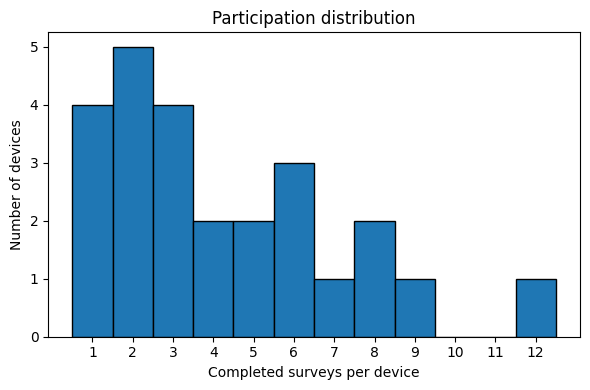

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Zahl Surveys je Gerät
survey_counts = (
    wide_df.groupby('device_id')['survey_num']
           .nunique()
)

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(
    survey_counts,
    bins=np.arange(1, survey_counts.max()+2),   # 1-schrittige Bins
    edgecolor='black',
    align='left'
)
ax.set_xlabel('Completed surveys per device')
ax.set_ylabel('Number of devices')
ax.set_title('Participation distribution')
ax.set_xticks(np.arange(1, survey_counts.max()+1))
plt.tight_layout()
plt.show()


In [16]:
slider_cols = [
    'general_wellbeing', 'content', 'tense_relaxed', 'awake',
    'environment_noise', 'environment_nature', 'environment_lively',
    'environmen_pleasure', 'sense_of_belonging'
]

wide_df[slider_cols].describe().T[['mean','std','min','25%','50%','75%','max']].round(2)


,mean,std,min,25%,50%,75%,max
general_wellbeing,0.67,0.19,0.00,0.57,0.69,0.79,1.0
content,0.65,0.22,0.00,0.56,0.67,0.80,1.0
tense_relaxed,0.58,0.24,0.00,0.38,0.62,0.76,1.0
awake,0.46,0.25,0.00,0.29,0.39,0.68,1.0
environment_noise,0.61,0.29,0.00,0.35,0.68,0.87,1.0
environment_nature,0.40,0.31,0.00,0.14,0.37,0.63,1.0
environment_lively,0.54,0.32,0.00,0.26,0.60,0.82,1.0
environmen_pleasure,0.71,0.24,0.01,0.59,0.77,0.90,1.0
sense_of_belonging,0.75,0.26,0.01,0.63,0.81,0.98,1.0


In [17]:
cat_cols = ['activity', 'location_category', 'indoors_outdoors', 'people_with_you']
for col in cat_cols:
    print(f"\n—— {col} ———————————————")
    print(wide_df[col].value_counts(dropna=False)[:15])



—— activity ———————————————
activity
working / studying                                         48
leisure / relaxation                                       19
travelling / commuting                                      9
cooking / eating                                            4
using media                                                 4
shopping / errands                                          2
working / studying;social activities                        2
leisure / relaxation;using media                            2
social activities;working / studying                        2
leisure / relaxation;cooking / eating                       2
resting / sleeping                                          2
housework / tidying                                         2
social activities;cooking / eating;leisure / relaxation     1
working / studying;travelling / commuting                   1
cooking / eating;social activities                          1
Name: count, dtype: int64

—— lo

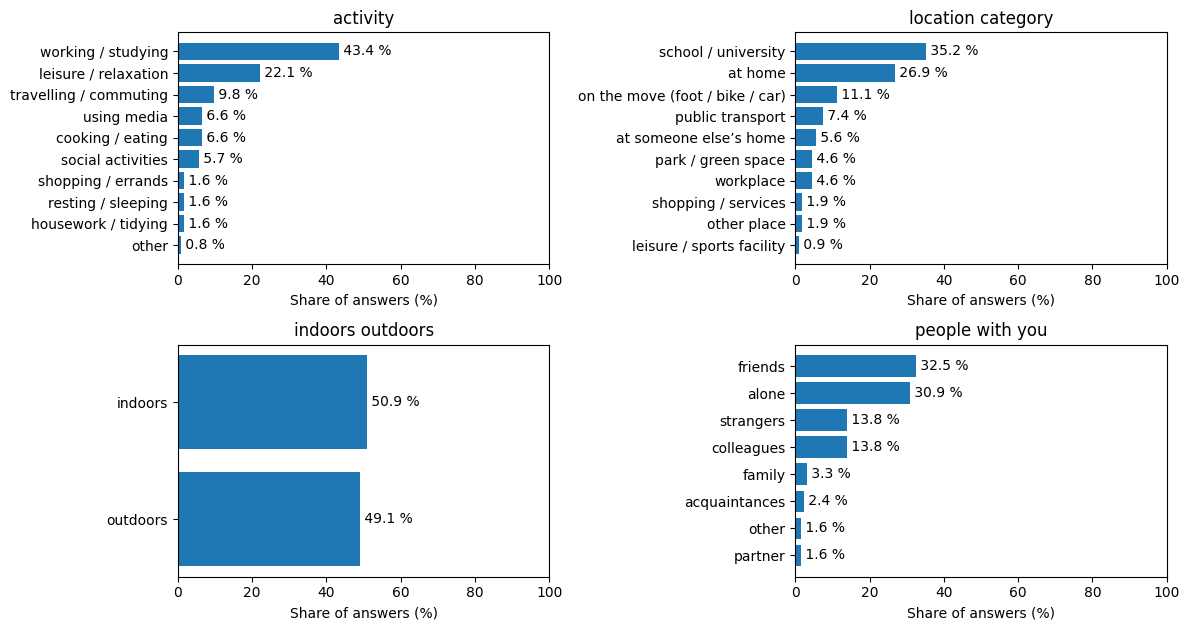

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

cat_cols = ['activity', 'location_category',
            'indoors_outdoors', 'people_with_you']

n_cols = 2
n_rows = int(np.ceil(len(cat_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(12, 3.2 * n_rows),
                         sharex=False)
axes = axes.flatten()

for ax, col in zip(axes, cat_cols):
    # Mehrfachantworten trennen ↦ Häufigkeiten
    counts = (
        wide_df[col]
        .fillna('missing')
        .str.split(';')
        .explode()
        .value_counts()
        .sort_values()          # aufsteigend für horizontale Balken
    )

    # -> Prozentanteile
    pct = counts / counts.sum() * 100

    ax.barh(pct.index, pct.values)
    ax.set_title(col.replace('_', ' '))
    ax.set_xlabel('Share of answers (%)')
    ax.set_xlim(0, 100)

    # Prozentwerte an den Balken
    for y, v in enumerate(pct.values):
        ax.text(v, y, f' {v:.1f} %', va='center', ha='left')

plt.tight_layout()
plt.show()


/var/folders/sf/c6nlqdjd2l3fb94dxdrh91vm0000gn/T/ipykernel_31637/3440719561.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, vert=False, labels=order, patch_artist=True)


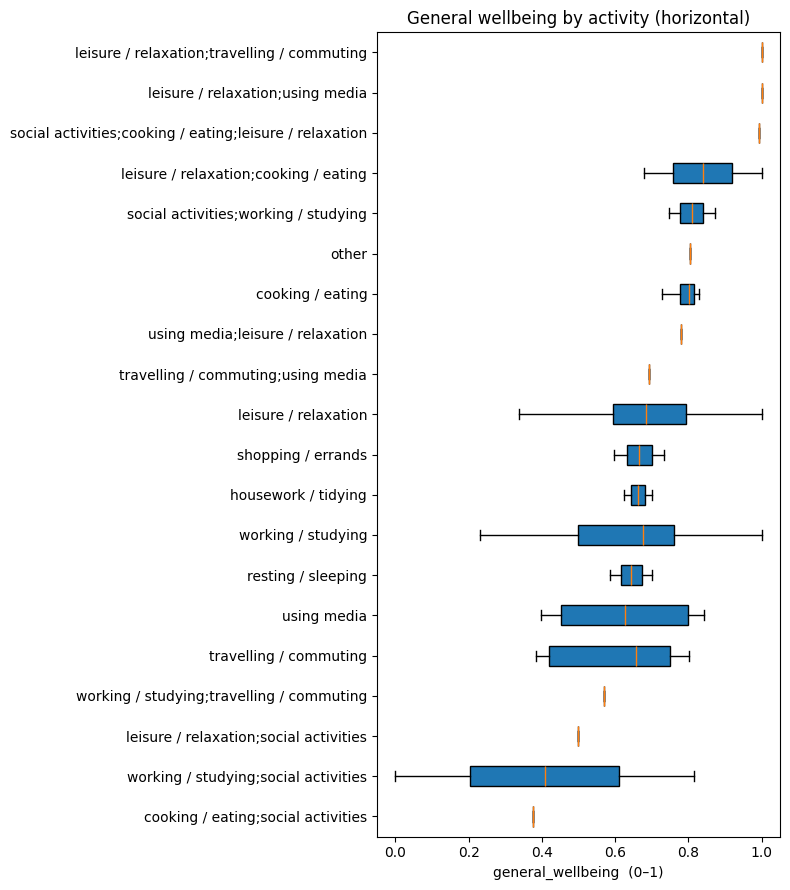

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Reihenfolge nach Mittelwert sortieren
order = (wide_df
         .groupby('activity')['general_wellbeing']
         .mean()
         .sort_values()
         .index.tolist())

# Daten in der gewünschten Reihenfolge einsammeln
data = [wide_df.loc[wide_df['activity'] == act,
                    'general_wellbeing'].dropna()
        for act in order]

fig, ax = plt.subplots(figsize=(8, .45 * len(order)))      # Höhe dynamisch
ax.boxplot(data, vert=False, labels=order, patch_artist=True)

ax.set_xlabel('general_wellbeing  (0–1)')
ax.set_title('General wellbeing by activity (horizontal)')
plt.tight_layout()
plt.show()


Formel (gekürzt): general_wellbeing ~ environment_noise + environment_nature + environment_lively + environmen_pleasure + content + tense_relaxed + awake + se …


/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/numpy/linalg/_linalg.py:2373: RuntimeWarning: divide by zero encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/numpy/linalg/_linalg.py:2373: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/numpy/linalg/_linalg.py:2373: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization 

                                 Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              general_wellbeing
No. Observations:                106                  Method:                          REML             
No. Groups:                      25                   Scale:                           0.0118           
Min. group size:                 1                    Log-Likelihood:                  13.0003          
Max. group size:                 12                   Converged:                       No               
Mean group size:                 4.2                                                                    
--------------------------------------------------------------------------------------------------------
                                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------

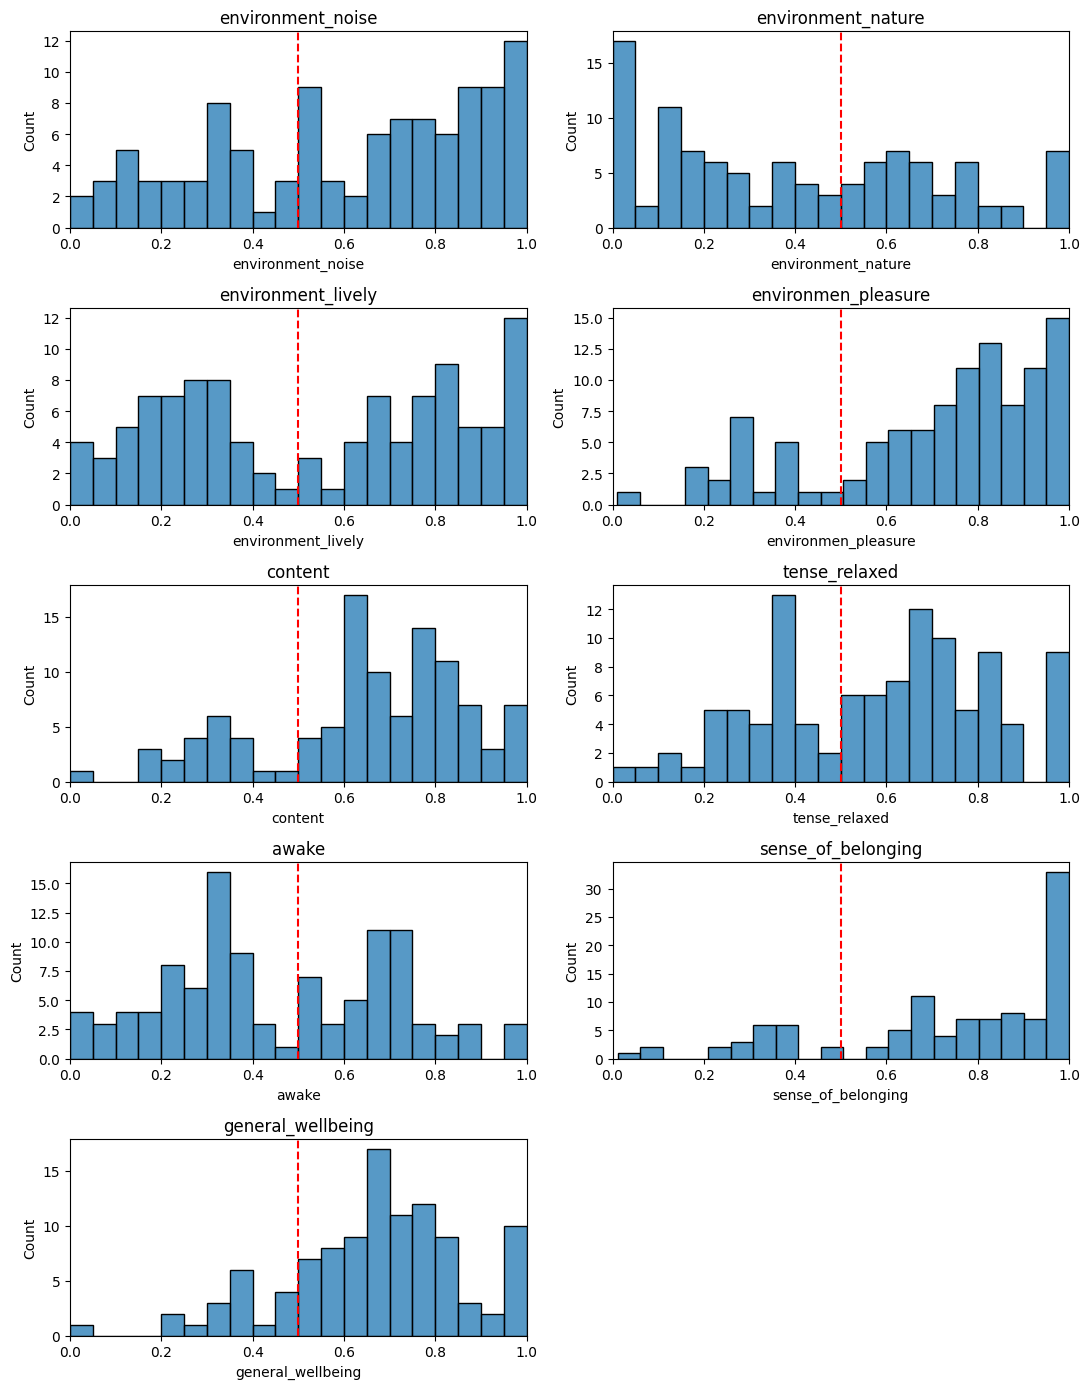

/var/folders/sf/c6nlqdjd2l3fb94dxdrh91vm0000gn/T/ipykernel_31637/4267694483.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pct, y=labels, ax=ax, palette="Blues_d")
/var/folders/sf/c6nlqdjd2l3fb94dxdrh91vm0000gn/T/ipykernel_31637/4267694483.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pct, y=labels, ax=ax, palette="Blues_d")
/var/folders/sf/c6nlqdjd2l3fb94dxdrh91vm0000gn/T/ipykernel_31637/4267694483.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pct, y=labels, ax=ax, palette="Blues_d")
/var/folders/sf/c6nlqdjd2l3fb94

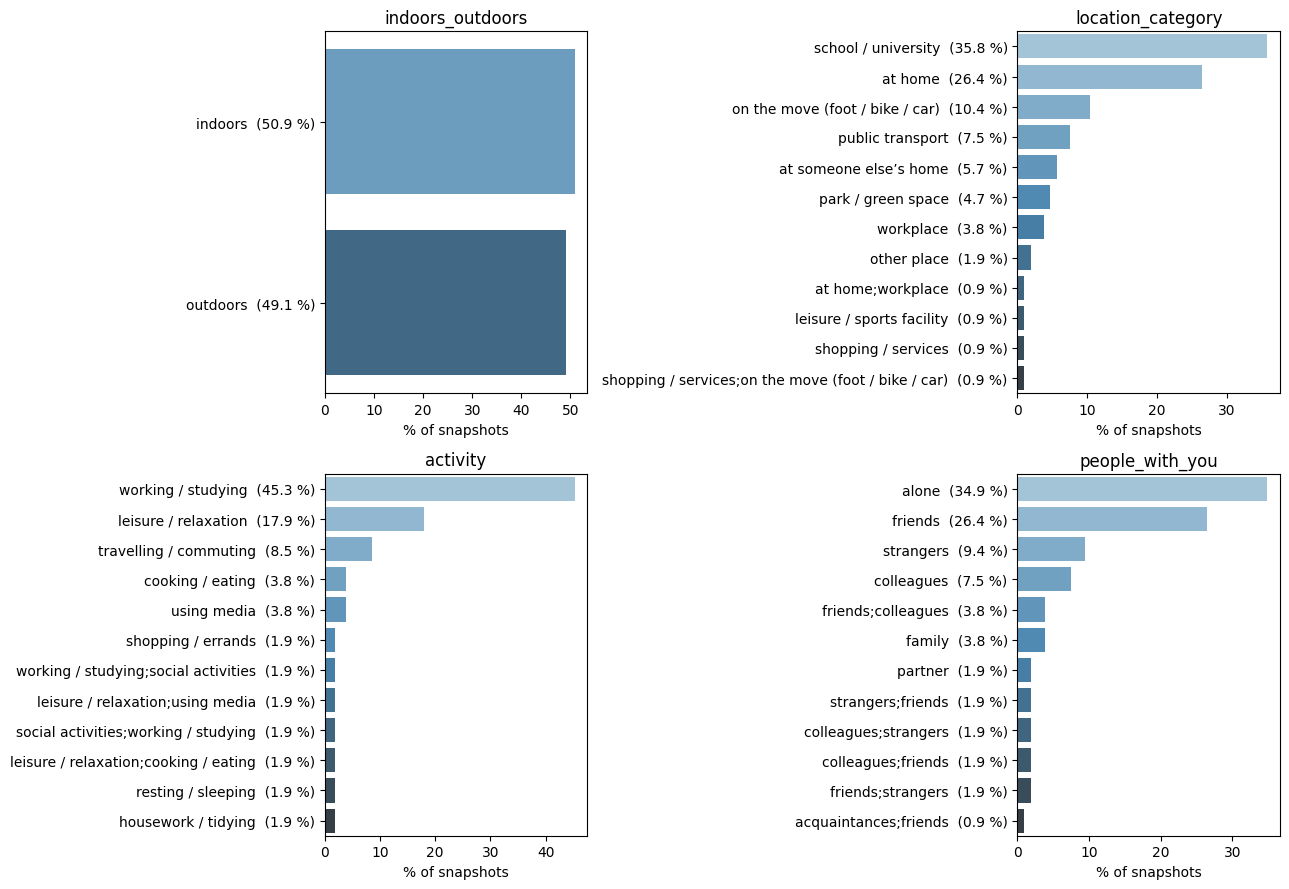

Cramér-V: 0.586


/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_model.py:2458: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params())[0:p])
/var/folders/sf/c6nlqdjd2l3fb94dxdrh91vm0000gn/T/ipykernel_31637/4267694483.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="coef",y="name",data=sig,
/var/folders/sf/c6nlqdjd2l3fb94dxdrh91vm0000gn/T/ipykernel_31637/4267694483.py:126: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(x="coef",y="name",data=sig,


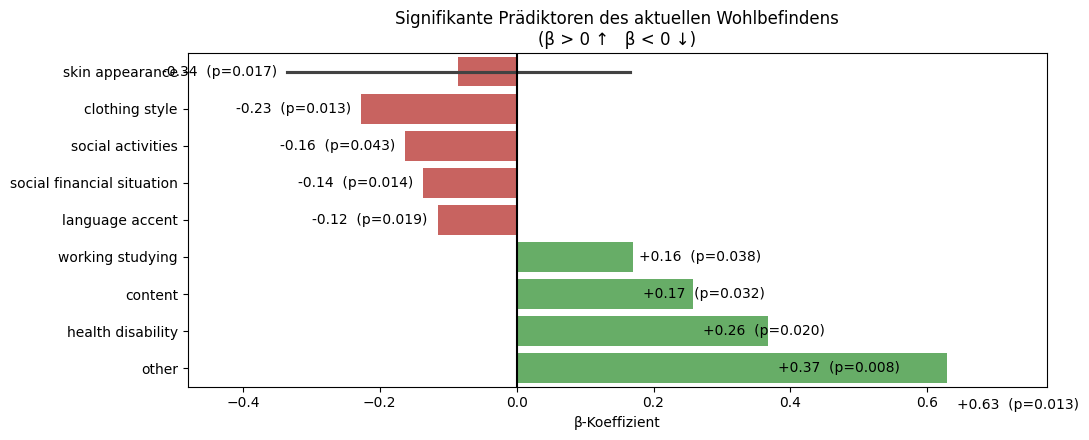

In [20]:
###############################################################################
# ANALYSE-BLOCK  –  inkl. Mixed-Effects-Modell + Plots                        #
###############################################################################
import re, json, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency, norm

# ---------------------------------------------------------------------------
# 0) SPALTENLISTEN, SLUG-Helfer, Plottechnik
# ---------------------------------------------------------------------------
slider_cols  = ["environment_noise", "environment_nature", "environment_lively",
                "environmen_pleasure", "content", "tense_relaxed", "awake",
                "sense_of_belonging", "general_wellbeing"]

single_cat   = ["indoors_outdoors", "location_category"]
multi_cat    = ["activity", "people_with_you",
                "factors_sense_of_belonging", "majority_comparison"]

def slug(txt: str) -> str:
    return re.sub(r"__+", "_",
           re.sub(r"[^A-Za-z0-9_]+", "_", txt)).strip("_").lower()

# ----------  kleine Hilfs-Funktion für Balkenplots (jetzt GANZ OBEN!) -------
def bar_pct(series, title, ax, top_n=12):
    """Balkenplot mit Prozentangabe im Label."""
    vc   = series.value_counts(dropna=False).head(top_n)
    pct  = (vc/len(series)*100).round(1)
    labels = [f"{idx}  ({p} %)" for idx, p in zip(vc.index, pct)]
    sns.barplot(x=pct, y=labels, ax=ax, palette="Blues_d")
    ax.set_title(title);  ax.set_xlabel("% of snapshots")

# ---------------------------------------------------------------------------
# 1) SLIDER in numerisch, auf Neutralwert 0 zentriert (0.5 → 0)
# ---------------------------------------------------------------------------
df = wide_df.copy()
df[slider_cols] = df[slider_cols].apply(pd.to_numeric, errors="coerce") - 0.5

# ---------------------------------------------------------------------------
# 2) DESIGN-MATRIX  X  (Slider + One-Hot für alle Kategorien)
# ---------------------------------------------------------------------------
X_parts = [df[[c for c in slider_cols if c != "general_wellbeing"]]]

for col in single_cat:
    X_parts.append(pd.get_dummies(df[col], prefix=slug(col), drop_first=True))

def explode_multiselect(series):
    codes = (series.dropna().str.split(";").explode().str.strip().unique())
    dummy = pd.DataFrame(0, index=series.index, columns=codes)
    for idx, cell in series.items():
        if pd.isna(cell): continue
        for c in cell.split(";"): dummy.at[idx, c.strip()] = 1
    return dummy.add_prefix(f"{slug(series.name)}_")

for col in multi_cat:
    X_parts.append(explode_multiselect(df[col]))

X = pd.concat(X_parts, axis=1).astype(float)
X.columns = [slug(c) for c in X.columns]

# ---------------------------------------------------------------------------
# 3) Intersection-Beispiel  (Gender ∩ Age)
# ---------------------------------------------------------------------------
df["oppress_gender_and_age"] = (
    df["axis_of_opression"].fillna("").str.contains("gender") &
    df["axis_of_opression"].str.contains("age")
).astype(int)
X["oppress_gender_and_age"] = df["oppress_gender_and_age"]

# ---------------------------------------------------------------------------
# 4) Mixed-Effects-Modell
# ---------------------------------------------------------------------------
y       = df["general_wellbeing"]
groups  = df["device_id"]
data_m  = pd.concat([y.rename("general_wellbeing"), groups, X], axis=1).dropna()

formula = "general_wellbeing ~ " + " + ".join(X.columns)
print("Formel (gekürzt):", formula[:140], "…")

mfit = smf.mixedlm(formula, data=data_m,
                   groups=data_m["device_id"],
                   re_formula="1").fit(method="lbfgs")
print(mfit.summary())

# ---------------------------------------------------------------------------
# 5) Histos der Slider (rote Linie = neutral 0.5)
# ---------------------------------------------------------------------------
fig, axes = plt.subplots((len(slider_cols)-1)//2+1, 2, figsize=(11,14)); axes=axes.flatten()
for ax, col in zip(axes, slider_cols):
    sns.histplot(wide_df[col], bins=20, ax=ax)
    ax.axvline(0.5, ls="--", c="red"); ax.set(title=col, xlim=(0,1))
for ax in axes[len(slider_cols):]: ax.axis("off")
plt.tight_layout(); plt.show()

# ---------------------------------------------------------------------------
# 6) Balkenplots – jetzt ohne NameError
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(13,9)); axes=axes.flatten()
cols_plot = single_cat + ["activity", "people_with_you"]
for ax, col in zip(axes, cols_plot):
    bar_pct(df[col].fillna("Missing"), col, ax)
for ax in axes[len(cols_plot):]: ax.axis("off")
plt.tight_layout(); plt.show()

# ---------------------------------------------------------------------------
# 7) Beispiel-Cramér-V  (activity × location_category)
# ---------------------------------------------------------------------------
def cramers_v(x,y):
    tab=pd.crosstab(x,y); chi2=chi2_contingency(tab,False)[0]
    n=tab.to_numpy().sum(); r,k=tab.shape
    return np.sqrt(chi2/(n*(min(r,k)-1)))
print("Cramér-V:", cramers_v(df["activity"].fillna("None"),
                              df["location_category"].fillna("None")).round(3))

# ---------------------------------------------------------------------------
# 8) Signifikante Fixed-Effects hübsch plotten
# ---------------------------------------------------------------------------
fe = pd.DataFrame({"coef": mfit.fe_params, "se": mfit.bse_fe})
fe["p"] = 2*(1-norm.cdf(np.abs(fe["coef"]/fe["se"])))
sig = fe[fe["p"]<.05].sort_values("coef")
if sig.empty:
    print("Keine signifikanten Effekte.")
else:
    def nice(n): return re.sub(r"^(factors_sense_of_belonging_|majority_comparison_|location_category_|people_with_you_|activity_)", "", n).replace("_"," ")
    sig["name"]=sig.index.map(nice); rng=sig["coef"].max()-sig["coef"].min(); pad=rng*0.15 or 0.2
    plt.figure(figsize=(11,max(2.5,len(sig)*0.45)))
    sns.barplot(x="coef",y="name",data=sig,
                palette=["#d9534f" if c<0 else "#5cb85c" for c in sig["coef"]])
    plt.axvline(0,c="k"); plt.xlim(sig["coef"].min()-pad,sig["coef"].max()+pad)
    for y,(c,p) in enumerate(zip(sig["coef"],sig["p"])):
        plt.text(c+np.sign(c)*pad*0.1, y, f"{c:+.2f}  (p={p:.3f})",
                 va="center", ha="left" if c>0 else "right")
    plt.title("Signifikante Prädiktoren des aktuellen Wohlbefindens\n(β > 0 ↑   β < 0 ↓)")
    plt.xlabel("β-Koeffizient"); plt.ylabel(""); plt.tight_layout(); plt.show()


In [21]:
###############################################################################
# FREITEXT-ANTWORTEN SAMMELN (other_factors_*  –  930 & 940)                  #
###############################################################################
import pandas as pd

# ❶ Spalten, die Freitext enthalten
free_cols = ["other_factors_negative", "other_factors_positive"]

# ❷ Säubern-Funktion: NaNs raus, Leerraum trimmen, Zeilenumbrüche ersetzen
def collect_text(series: pd.Series) -> list[str]:
    return (series.dropna()                  # NaN entfernen
                  .astype(str)               # sicher als String
                  .str.replace(r"\s+", " ", regex=True)  # Mehrfach-Whitespace → Space
                  .str.strip()               # vorne/hinten trimmen
                  .loc[lambda s: s != ""]    # leere Strings verwerfen
                  .unique()                  # Duplikate entfernen
                  .tolist())

# ❸ Ergebnisse als Dictionary – übersichtlicher & weiterverwendbar
free_text_responses = {col: collect_text(wide_df[col]) for col in free_cols}

# ❹ Ausgabe
for col, lst in free_text_responses.items():
    print(f"\n— {col}  ({len(lst)} einzigartige Antworten) —")
    for i, txt in enumerate(lst, 1):
        print(f"{i:>2}. {txt}")



— other_factors_negative  (11 einzigartige Antworten) —
 1. heat
 2. Everyone is doing the same, so it kind of feels like being at the right place
 3. The contact with strangers
 4. Bed
 5. health issues
 6. no natural sunlight room without windows no fresh air
 7. a lot of people - personal space
 8. No
 9. /
10. no
11. Not really

— other_factors_positive  (7 einzigartige Antworten) —
 1. place i know and is mine i have control over it
 2. know this place and can do what i want
 3. my room and cozy for the night
 4. pets
 5. spending time with family pets
 6. I am not by myself
 7. Less noise from construction works


In [22]:
###############################################################################
# INTERAKTIVE KARTE MIT ALLEN SURVEYS (Folium + MarkerCluster)                #
###############################################################################
import folium
from folium.plugins import MarkerCluster
import pandas as pd

# ------------------------------------------------------------------
# 1) Koordinaten filtern
# ------------------------------------------------------------------
cols_geo = ["location_lat", "location_lng", "survey_created_at",
            "device_id", "activity", "general_wellbeing"]
geo_df = (wide_df[cols_geo]
          .dropna(subset=["location_lat","location_lng"]))

print(f"{len(geo_df):,} Surveys mit Geo-Daten gefunden.")

# ------------------------------------------------------------------
# 2) Grundkarte zentrieren
# ------------------------------------------------------------------
center = [geo_df["location_lat"].mean(), geo_df["location_lng"].mean()]
m = folium.Map(location=center, zoom_start=9, tiles="CartoDB positron")

# ------------------------------------------------------------------
# 3) MarkerCluster mit Pop-ups
# ------------------------------------------------------------------
mc = MarkerCluster().add_to(m)

for _, row in geo_df.iterrows():
    popup = folium.Popup(
        f"<b>{row['activity']}</b><br>"
        f"wb&nbsp;= {row['general_wellbeing']:.2f}<br>"
        f"{pd.to_datetime(row['survey_created_at']).strftime('%Y-%m-%d&nbsp;%H:%M')}"
        f"<br>device&nbsp;= {row['device_id']}",
        max_width=80
    )
    folium.CircleMarker(
        location=[row["location_lat"], row["location_lng"]],
        radius=4, weight=1, color="#3388ff", fill=True, fill_opacity=0.7,
        popup=popup
    ).add_to(mc)

# ------------------------------------------------------------------
# 4) Karte anzeigen
# ------------------------------------------------------------------
m


106 Surveys mit Geo-Daten gefunden.


In [23]:
wide_df.head()

,device_id,survey_num,survey_created_at,location_lat,location_lng,activity,awake,axis_of_opression,content,environmen_pleasure,environment_lively,environment_nature,environment_noise,factors_sense_of_belonging,general_wellbeing,indoors_outdoors,location_category,majority_comparison,other_factors_negative,other_factors_positive,people_with_you,sense_of_belonging,tense_relaxed
0,1IIJ-CDFW-46VP,1,2025-05-13 07:48:25.865281,46.950286,7.438392,working / studying,0.830619,axis_of_opression_no,0.775244,0.879479,0.105863,0.599349,0.342020,no,0.724756,outdoors,workplace,gender;age;skin / appearance;sexual orientatio...,NaN,NaN,colleagues,0.936482,0.775244
1,1IIJ-CDFW-46VP,2,2025-05-13 12:52:34.345000,46.947910,7.377243,working / studying,0.565147,NaN,0.654723,0.289902,0.289902,0.392508,0.078176,no,0.687296,outdoors,on the move (foot / bike / car),gender;skin / appearance;language / accent;hea...,heat,NaN,colleagues,0.631922,0.667752
2,1IIJ-CDFW-46VP,3,2025-05-16 06:30:37.765026,46.961244,7.451015,cooking / eating,0.563518,NaN,0.825733,0.912052,0.701954,0.442997,0.785016,no,0.811075,indoors,at home,age;background;skin / appearance;language / ac...,NaN,NaN,partner,1.000000,0.825733
3,1IIJ-CDFW-46VP,4,2025-05-16 12:40:51.991116,46.961188,7.451114,leisure / relaxation,0.874593,NaN,0.838762,0.915309,0.827362,0.804560,0.804560,no,0.786645,indoors,at home,alone (no comparison),NaN,NaN,alone,1.000000,0.899023
4,1SMH-8HOX-E1HX,1,2025-05-13 07:41:56.654428,46.950313,7.438403,working / studying,0.406154,axis_of_opression_yes_because_of_my_social_or_...,0.595897,0.394872,0.530256,0.367179,0.343590,no,0.595897,outdoors,school / university,age;background;language / accent;health / disa...,NaN,NaN,friends,0.664615,0.372308


In [24]:
demo_all.head()

,age_group_lbl,axis_codes_lbl,different_country_than_born_in_lbl,disabilities_lbl,education_lbl,employment_status_lbl,gender_lbl,household_members_financing_lbl,household_members_lbl,info_questions_about_you,monthly_household_income_lbl,n_surveys,sex_lbl,sexual_orientation_lbl
device_id,,,,,,,,,,,,,,
1IIJ-CDFW-46VP,NaN,no,no,no,university degree,employed,man,2 earners,3,NaN,> CHF 10 000,4,female,straight / hetero
1SMH-8HOX-E1HX,16–25,social / financial,no,no,Matura / equivalent,student / pupil,man,2 earners,5,NaN,> CHF 10 000,3,female,straight / hetero
20LN-4X5H-UXWX,NaN,clothing / style,NaN,no,Matura / equivalent,employed,trans man,6 earners,6,NaN,CHF 6 000 – 7 500,1,female,asexual
4RKD-HU7N-HXI2,NaN,no,no,no,Matura / equivalent,student / pupil,man,3 earners,3,NaN,CHF 3 000 – 4 500,1,female,straight / hetero
678K-202G-SYCD,16–25,NaN,no,no,Matura / equivalent,student / pupil,man,2 earners,1 (living alone),NaN,< CHF 1 500,4,female,straight / hetero


In [ ]:
###############################################################################
# INTERSEKTION-ANALYSE  (ETA-Bar + Cache + schneller Batch-Fit)               #
###############################################################################
import itertools, gc, re, time, json, pickle, hashlib, os, warnings, numpy as np
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from joblib import Parallel, delayed, parallel_backend
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from statsmodels.stats.multitest import multipletests

warnings.filterwarnings("ignore", message="The global interpreter lock")

t0_global = time.perf_counter()      # Gesamt-Timer

# ════════════════════════════════════════════════════════════════════════════
# 0) DEMOGRAFIE anhängen
# ════════════════════════════════════════════════════════════════════════════
demo_single = [
    "age_group_lbl","sex_lbl","gender_lbl","education_lbl","employment_status_lbl",
    "disabilities_lbl","different_country_than_born_in_lbl","household_members_lbl",
    "household_members_financing_lbl","monthly_household_income_lbl",
    "sexual_orientation_lbl",
]
demo_multi  = ["axis_codes_lbl"]

df_all = (wide_df
          .join(demo_all[demo_single + demo_multi], on="device_id", how="left"))

# ════════════════════════════════════════════════════════════════════════════
# 1) BASIS-FEATURES
# ════════════════════════════════════════════════════════════════════════════
slider_cols = ["environment_noise","environment_nature","environment_lively",
               "environmen_pleasure","content","tense_relaxed","awake",
               "sense_of_belonging"]

snap_bin = X.reindex(df_all.index)          # Index an df_all angleichen!

# -- Demografie --------------------------------------------------------------
parts = [
    pd.get_dummies(df_all[demo_single], prefix_sep="__", drop_first=True)
]

def multiselect_dummies(s: pd.Series, pref=""):
    codes   = s.dropna().str.split(";").explode().str.strip().unique()
    mat     = np.zeros((len(s), len(codes)), dtype=np.int8)
    lookup  = {c:i for i,c in enumerate(codes)}
    for row, cell in enumerate(s):
        if pd.isna(cell):
            continue
        for c in cell.split(";"):
            mat[row, lookup[c.strip()]] = 1
    return pd.DataFrame(mat, index=s.index,
                        columns=[pref + c for c in codes])

parts.append(multiselect_dummies(df_all["axis_codes_lbl"], "axis__"))
demo_bin = pd.concat(parts, axis=1)

# -- Gesamt-Matrix (2 Schritte!) ---------------------------------------------
X_full = pd.concat([
            df_all[slider_cols],   # ❶ Slider
            snap_bin,              # ❷ Momentaufnahme-Dummies
            demo_bin               # ❸ Demografie-Dummies
         ], axis=1).fillna(0)

# Duplikate erst JETZT entfernen
X_full = X_full.loc[:, ~X_full.columns.duplicated()]

bin_cols = [c for c in X_full.columns if set(X_full[c].unique()) <= {0,1}]
print(f"{len(bin_cols)} binäre Grund-Prädiktoren")

# ════════════════════════════════════════════════════════════════════════════
# 2)  APRIORI-INTERAKTIONEN bis MAX_ORDER                                     #
# ════════════════════════════════════════════════════════════════════════════
MAX_ORDER   = 6        # ↑=explosiv
MIN_SUPPORT = 10       # mind. so viele 1-en im Datensatz

Xb = X_full[bin_cols].to_numpy(dtype=bool)
p  = len(bin_cols)

def name_from_key(key): return "__AND__".join(bin_cols[i] for i in key)

new_names, L_prev = [], { (i,): Xb[:,i] for i in range(p) if Xb[:,i].sum()>=MIN_SUPPORT }

for k in range(2, MAX_ORDER+1):
    tic, cand = time.perf_counter(), {}
    prev_keys = sorted(L_prev)
    tot = len(prev_keys)*(len(prev_keys)-1)//2
    with tqdm(total=tot, desc=f"Ordnung {k}", unit="comb") as bar:
        for i,a in enumerate(prev_keys):
            va = L_prev[a]
            for j in range(i+1, len(prev_keys)):
                b = prev_keys[j]
                if a[:-1]!=b[:-1]: break
                key = (*a, b[-1])
                if key in cand: continue
                vb = L_prev[b]
                v  = va & vb
                if v.sum() >= MIN_SUPPORT: cand[key]=v
                bar.update(1)
            bar.update(len(prev_keys)-j-1)
    if not cand: break
    block      = np.column_stack(list(cand.values())).astype(np.int8)
    block_cols = [name_from_key(k) for k in cand]
    X_full[block_cols] = block        # blockwrite → keine Fragmentierung
    new_names.extend(block_cols)
    L_prev = cand
    print(f"  +{len(block_cols):,} neue Features  |  {time.perf_counter()-tic:4.1f}s")

print(f"GESAMT: {len(new_names):,} Interaktions-Spalten (≤{MAX_ORDER}-way)"
      f"  in {time.perf_counter()-t0_global:4.1f}s")

# ════════════════════════════════════════════════════════════════════════════
# 3)  ELASTIC-NET (CV)                                                        #
# ════════════════════════════════════════════════════════════════════════════
y   = df_all["general_wellbeing"].astype(float)
Xs  = StandardScaler(with_mean=False).fit_transform(X_full)

tic = time.perf_counter()
enet = ElasticNetCV(l1_ratio=.9, cv=5, n_jobs=-1,
                    max_iter=20_000, random_state=42).fit(Xs, y)
print(f"Elastic-Net fertig in {time.perf_counter()-tic:4.2f}s")

coef_ser = pd.Series(enet.coef_, index=X_full.columns)
coef_int = coef_ser[new_names]

# ════════════════════════════════════════════════════════════════════════════
# 4)  PERMUTATION-TESTS  (Cache + echte ETA via tqdm_joblib)                  #
# ════════════════════════════════════════════════════════════════════════════
N_PERM, TOP_N, JOBS = 200, 500, max(1, os.cpu_count()-1)
CACHE = Path("cache_intersect"); CACHE.mkdir(exist_ok=True)

meta = dict(n_perm=N_PERM, top=TOP_N, max_order=MAX_ORDER,
            l1=.9, shape=X_full.shape,
            y_md5=hashlib.md5(y.to_numpy().tobytes()).hexdigest())
meta_f = CACHE/"meta.json";  res_f=CACHE/"results.feather";  null_f=CACHE/"null.npy"

cache_ok = all(p.exists() for p in (meta_f,res_f,null_f)) \
           and json.loads(meta_f.read_text())==meta

if cache_ok:
    print("⚡ Perm-Ergebnisse aus Cache")
    results   = pd.read_feather(res_f).set_index("feat")
    coef_null = np.load(null_f)
else:
    cand = (coef_int.abs().sort_values(ascending=False)
            .head(TOP_N).index)
    idx  = [X_full.columns.get_loc(c) for c in cand]

    # --- tqdm-joblib Patch --------------------------------------------------
    from tqdm_joblib import tqdm_joblib
    def perm_beta(seed):
        rng = np.random.default_rng(seed)
        est = ElasticNetCV(l1_ratio=.9, cv=5, n_jobs=1,
                           max_iter=20_000, random_state=seed)
        est.fit(Xs, rng.permutation(y))
        return est.coef_[idx].astype(np.float32)

    print(f"Permutation-Tests  ({N_PERM}×, {JOBS} Kerne)")
    with tqdm_joblib(tqdm(total=N_PERM, desc="Perm-Fits", unit="perm")):
        coef_null = np.vstack(Parallel(n_jobs=JOBS, backend="loky")(
                              delayed(perm_beta)(s) for s in range(N_PERM)))

    beta_obs = coef_int[cand].values
    p_perm   = (np.abs(beta_obs)[:,None] < np.abs(coef_null)).mean(1)
    rej, q   = multipletests(p_perm, .10, method="fdr_bh")[:2]

    results = pd.DataFrame(dict(feat=cand, β=beta_obs, p=p_perm, q=q, sig=rej)
               ).set_index("feat")

    # --- Cache speichern ----------------------------------------------------
    results.reset_index().to_feather(res_f)
    np.save(null_f, coef_null)
    meta_f.write_text(json.dumps(meta))
    print("💾 Perm-Ergebnisse gecached")

sig_pos = results.query("sig & β > 0")
sig_neg = results.query("sig & β < 0")
print(f"Signifikant @ FDR 10 %  →  +{len(sig_pos)} | −{len(sig_neg)}")

# ════════════════════════════════════════════════════════════════════════════
# 5)  VISUALISIERUNG  (Heatmaps Top 20)                                       #
# ════════════════════════════════════════════════════════════════════════════
def tidy(n):
    return (n.replace("__AND__", " ∧ ").replace("location_category__", "loc:")
             .replace("people_with_you__", "pw:").replace("activity_", "act:")
             .replace("axis__", "axis:").replace(
                 "factors_sense_of_belonging__", "fsb:")
             .replace("majority_comparison__", "mc:"))

def heat(df, title, cmap):
    if df.empty: return
    top = df.nlargest(20, "β") if cmap=="Greens" else df.nsmallest(20, "β")
    mat = top["β"].to_frame();  mat.index = mat.index.map(tidy)
    plt.figure(figsize=(11, .45*len(mat)+2))
    sns.heatmap(mat, annot=True, fmt="+.3f", cmap=cmap,
                cbar_kws=dict(label="β (Elastic-Net)"), linewidths=.6)
    plt.title(title); plt.ylabel(""); plt.xlabel(""); plt.tight_layout(); plt.show()

heat(sig_pos, "Interaktionen ↗ Wohlbefinden", "Greens")
heat(sig_neg, "Interaktionen ↘ Wohlbefinden", "Reds_r")

print(f"\n✧ Gesamtlaufzeit: {time.perf_counter()-t0_global:6.1f}s")


83 binäre Grund-Prädiktoren


Ordnung 2: 100%|██████████| 1081/1081 [00:00<00:00, 56194.37comb/s]


  +402 neue Features  |   0.1s


Ordnung 3: 100%|█████████▉| 80203/80601 [00:00<00:00, 7777756.90comb/s]


  +1,378 neue Features  |   0.3s


Ordnung 4: 100%|█████████▉| 947376/948753 [00:00<00:00, 51925970.24comb/s]


  +2,334 neue Features  |   0.8s


Ordnung 5: 100%|█████████▉| 2720278/2722611 [00:00<00:00, 161058029.09comb/s]


  +2,436 neue Features  |   1.3s


Ordnung 6: 100%|█████████▉| 2963395/2965830 [00:00<00:00, 279594635.07comb/s]


  +1,747 neue Features  |   1.2s
GESAMT: 8,297 Interaktions-Spalten (≤6-way)  in  3.7s


Perm-Fits:  14%|█▍        | 28/200 [09:26<20:59,  7.32s/perm]

Elastic-Net fertig in 7.09s
Permutation-Tests  (200×, 9 Kerne)



<frozen importlib._bootstrap>:488: RuntimeWarning: The global interpreter lock (GIL) has been enabled to load module 'sklearn.__check_build._check_build', which has not declared that it can run safely without the GIL. To override this behavior and keep the GIL disabled (at your own risk), run with PYTHON_GIL=0 or -Xgil=0.
<frozen importlib._bootstrap>:488: RuntimeWarning: The global interpreter lock (GIL) has been enabled to load module 'sklearn.__check_build._check_build', which has not declared that it can run safely without the GIL. To override this behavior and keep the GIL disabled (at your own risk), run with PYTHON_GIL=0 or -Xgil=0.
<frozen importlib._bootstrap>:488: RuntimeWarning: The global interpreter lock (GIL) has been enabled to load module 'sklearn.__check_build._check_build', which has not declared that it can run safely without the GIL. To override this behavior and keep the GIL disabled (at your own risk), run with PYTHON_GIL=0 or -Xgil=0.
<frozen importlib._bootstra